# Heatmap

In [1]:
import pandas as pd
import sys
sys.path.insert(0, '../scripts')
import EOL_tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read data

In [2]:
# read data
gc_file = '../data/all_growthcurves.tsv'

df_all_experiments = pd.read_csv(gc_file, sep='\t')
df_all_experiments['timedelta'] = pd.to_timedelta(df_all_experiments['timedelta'])
df_all_experiments['minutes'] = df_all_experiments['timedelta'].dt.total_seconds()/60

## Calculate liquid assay score

In [3]:
las_list = []

# per experiment in df
for experiment in df_all_experiments['experiment'].unique():
    
    # subset the dataframe
    df_experiment = df_all_experiments[df_all_experiments['experiment'] == experiment]
    
    # get the liquid assay score per experiment
    las_list.append(EOL_tools.las_experiment(df_experiment))

In [4]:
# make single dataframe
df_las = pd.concat(las_list)

In [5]:
#df_las.round(4).to_csv('../data/all_liquidasssayscores.tsv', sep='\t', index=None)

## Plot

In [6]:
df_las = pd.read_csv('../data/all_liquidasssayscores.tsv', sep='\t')

# remove bioreplicates
df_las = df_las[~df_las['strain'].isin(['ppu2', 'eco2'])]

In [7]:
# remove no phage rows and make into heatmap-style matrix
df_las_heatmap = df_las[df_las['phage'] != '-'].pivot(index='strain', columns='phage', values='las')

# ground everything at zero
df_las_heatmap[df_las_heatmap <= 0] = 0

# add missing phages to copy
df_full_heatmap = df_las_heatmap.copy()
missing = ['BCE1', 'PR4', 'PR5', 'L17', 'PR3', 'PR772']

for phage in missing:
    df_full_heatmap[phage] = [np.nan] * len(df_full_heatmap)

In [8]:
# define the order of the plot
df_order = pd.read_csv('../data/hm_order.tsv', sep='\t')
df_order = df_order[~df_order['name'].isin(['ppu2', 'eco2'])]

phage_order = df_order[df_order['type'] == 'phage'].sort_values('ord')['name'].to_list()
strain_order = df_order[df_order['type'] == 'strain'].sort_values('ord')['name'].to_list()

# reorder
df_fig = df_full_heatmap[phage_order]
df_fig = df_fig.reindex(strain_order)

In [9]:
# color palettes
greenish = sns.cubehelix_palette(start=2.8, rot=-.2, dark=0, light=.97, as_cmap=True)
blueish = sns.cubehelix_palette(start=2.9, rot=-.16, dark=0, light=.97, as_cmap=True)
new = sns.cubehelix_palette(start=3, rot=.5, gamma=1, hue=1, dark=0.1, light=.97, as_cmap=True)

background = '#ededf2'

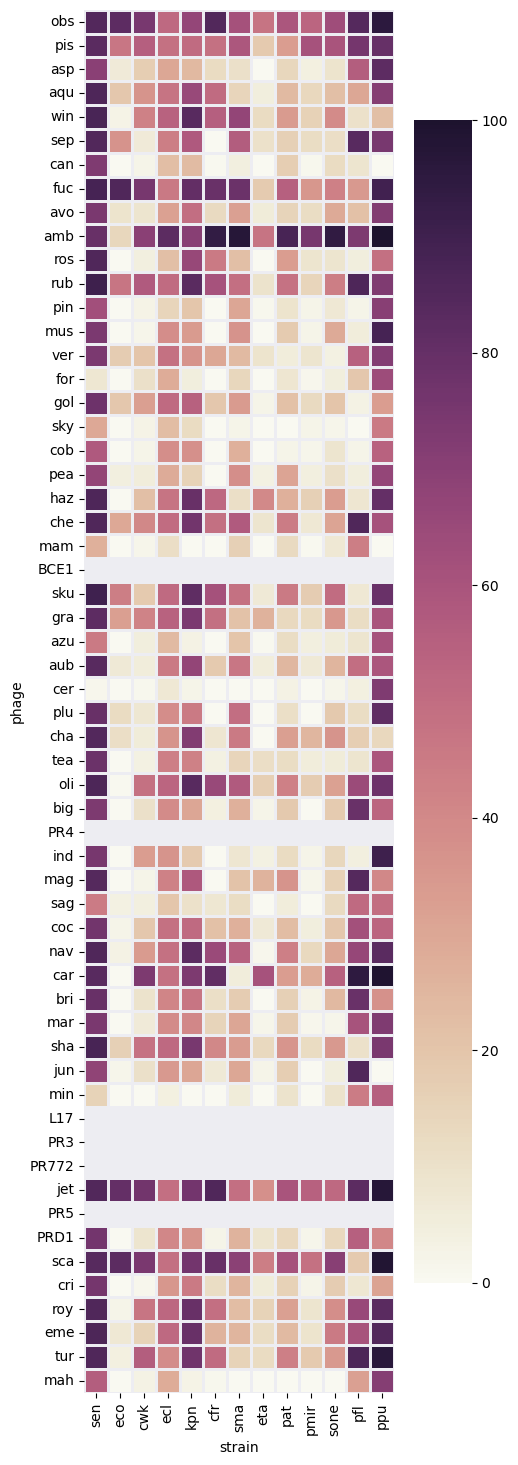

In [10]:
fig, axs = plt.subplots(1, 1,
                        figsize=(5,40))

g = sns.heatmap(df_fig.T,
                ax=axs,
                square=True,
                linewidths=1,
                linecolor=background,
                cmap=new,
                cbar=True,
                vmax=100)

g.set_facecolor(background)

# horizontal lines
#for i in range(df_fig.shape[1]+1):
 #   g.axhline(i, color='white', lw=2)

#plt.savefig('../data/svgs/hm.svg')
plt.show()